### Import

In [1]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image as image_utils
from collections import namedtuple

2023-08-24 11:17:29.234401: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 11:17:29.258548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 11:17:29.610954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Labels stuff

In [2]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [3]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

## Methods

### for data

In [4]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [5]:
def show_unique_values(df, col, display_pie=True, silent=False, cumul_threshold=85):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= cumul_threshold, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

In [6]:
def explore_data_folders(path):
    dict_cities = {
        'train': [],
        'val': [],
        'test': []
    }
    count_files_by_cities = {}
    
    # explore the folders data
    for root, dirs, files in os.walk(path):
        # print(root, dirs, len(files))
        
        # get the number of files by city
        if len(files) > 2:
            temp_city = root.split("/")[-1]
            count_files_by_cities[temp_city] = len(files)
        
        # get the list of cities
        if root.endswith(tuple(dict_cities.keys())):
            temp_key = root.split("/")[-1]
            dict_cities[temp_key] = dirs
    
    # verify the repartition of cities
    list_cities = list(dict_cities.values())
    # flatten list
    list_cities = [item for sublist in list_cities for item in sublist]
    print("Il y a", len(list_cities), "villes au total et", len(set(list_cities)), "villes uniques.")

    # to rank cities by the number of pictures
    count_files_by_cities = {k: v for k, v in sorted(count_files_by_cities.items(), key=lambda item: item[1])}
    print("Il y a", sum(count_files_by_cities.values()), "fichiers dans nos données.")
    return dict_cities, count_files_by_cities

### best stuff

In [7]:
labels

[Label(name='unlabeled', id=0, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='ego vehicle', id=1, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='rectification border', id=2, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='out of roi', id=3, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='static', id=4, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='dynamic', id=5, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(111, 74, 0)),
 Label(name='ground', id=6, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(81, 0, 81)),
 Label(name='road', id=7, trainId=0, category='flat', categoryId=

In [8]:
def load_data_from_json_files(begin_path, correspondig_dict_categ={}):
    start = time.time()
    raw_data = pd.DataFrame()
    for root, dirs, files in os.walk(begin_path):
        # print(root, dirs, files)
        if len(files) > 2:
            for elt in files:
                if elt.endswith("json"):
                    # load data
                    temp_path = root + "/" + elt
                    temp_df = pd.read_json(temp_path)

                    # convert dictionary objects into 2 columns
                    temp_df = pd.concat([temp_df.drop(['objects'], axis=1), temp_df['objects'].apply(pd.Series)], axis=1)

#                     # add few data into new columns
#                     split_name = elt.split("_")
#                     split_root = root.split("/")
#                     temp_df["city"] = split_name[0]
#                     temp_df["pic_id"] = "_".join(split_name[1:3])
#                     temp_df["set_type"] = split_root[-2]
                    
#                     # concatenante the data continuously
#                     raw_data = pd.concat([raw_data, temp_df])
                    
                
                    # load label ids data
                    # temp_path_label = temp_path.replace("polygons.json", "labelIds.png")
                    # img = image_utils.img_to_array(image_utils.load_img(temp_path_label))
                    # invent_ids = np.unique(img, return_counts=True)
                    
                    # add few data into new columns
                    split_name = elt.split("_")
                    split_root = root.split("/")
                    temp_df["city"] = split_name[0]
                    temp_df["pic_id"] = "_".join(split_name[1:3])
                    temp_df["set_type"] = split_root[-2]
                    # display(temp_df.head())
                    
                    # print([label.id for label in labels if label.name == "car"])
                    # temp_df["label_id"] = [label.id for label in labels if label.name == temp_df["label"]][0]
                    # temp_df["nb_label"] = 
                    # truc = bidule
                    # concatenante the data continuously
                    raw_data = pd.concat([raw_data, temp_df])
                    
                    
    # add main category aka main target with the correspondance
    if correspondig_dict_categ:
        flatten_dict = {val:key for key, lst in correspondig_dict_categ.items() for val in lst}
        raw_data["target"] = raw_data["label"].map(flatten_dict)
    
    end = time.time()
    delta = round(end - start, 0)
    print("Execution time of load_data_from_json_files() is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    return raw_data

# Explore the annoted pictures

In [9]:
dict_cities_annot, count_files_by_cities_annot = explore_data_folders("P8_Cityscapes_gtFine_trainvaltest/")

Il y a 27 villes au total et 27 villes uniques.
Il y a 20000 fichiers dans nos données.


Les données consistent en 4 fichiers de données pour une seule image brute : 
 - png avec les couleurs
 - png avec les ids des catégories
 - png avec les labels des catégories
 - json avec les catégories et les polygones

Il y a donc 20 000/4 = 5 000 images traitées.

## Explore json data

Le format des fichiers est le suivant : "nom ville" _ "code image sur 12 chiffres par groupe de 6" _ "nom dossier 'gtFine'" _ "extension"."format de fichier"

Les extensions sont color, instanceIds, labelIds et polygons.  
Les formats de ficher sont png et json.

La colonne 'objects' est un dictionnaire que l'on va convertir en nouvelles colonnes pour extraire le label.

Après avoir regardé les similarités et les différences entre toutes les sous-catégories, on arrive à cette liste de correspondances.

In [10]:
dict_categ_subcateg = {
    'flat': ['road', 'sidewalk', 'parking', 'rail track'],
    'human': ['person', 'rider', 'persongroup', 'ridergroup'],
    'vehicle': ["car", "truck", "bus", "motorcycle", "bicycle", "caravan", "trailer", "bicyclegroup", "motorcyclegroup", "train", "cargroup", "truckgroup", "license plate", "ego vehicle"],
    'construction': ["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    'object': ["pole", "traffic sign", "traffic light", "polegroup"],
    'nature': ["vegetation", "terrain"],
    'sky': ["sky"],
    'void': ["ground", "dynamic", "static", "rectification border", "out of roi"]
}

In [11]:
json_files_path = "P8_Cityscapes_gtFine_trainvaltest/gtFine/"

In [12]:
if os.path.exists("raw_data.csv"):
    raw_data = pd.read_csv("raw_data.csv", sep='\t', encoding='utf-8')
else:
    raw_data = load_data_from_json_files(json_files_path, correspondig_dict_categ=dict_categ_subcateg)
    raw_data.to_csv("raw_data.csv", sep='\t', encoding='utf-8')

Execution time of load_data_from_json_files() is: 60.0 s, soit 1.0 min, soit 0.0 h.


In [13]:
# label_list_from_data = raw_data["label"].unique()
# print(len(label_list_from_data))

# label_list_from_class_def = list(dict_categ_subcateg.values())
# label_list_from_class_def = [item for sublist in label_list_from_class_def for item in sublist]
# print(len(label_list_from_class_def))

# # difference = list(set(label_list_from_data) - set(label_list_from_class_def))
# difference = list(set(label_list_from_class_def) - set(label_list_from_data))
# print(difference, len(difference))

In [14]:
raw_data.head()

,imgHeight,imgWidth,label,polygon,city,pic_id,set_type,target
0,1024,2048,sky,"[[126, 9], [235, 182], [797, 315], [1045, 339]...",lindau,000057_000019,val,sky
1,1024,2048,road,"[[37, 561], [362, 514], [811, 398], [955, 361]...",lindau,000057_000019,val,flat
2,1024,2048,building,"[[1140, 324], [1139, 334], [1138, 337], [1123,...",lindau,000057_000019,val,construction
3,1024,2048,vegetation,"[[1129, 376], [1127, 371], [1127, 369], [1125,...",lindau,000057_000019,val,nature
4,1024,2048,building,"[[1073, 337], [1072, 294], [1055, 291], [1049,...",lindau,000057_000019,val,construction


In [15]:
raw_data.tail()

,imgHeight,imgWidth,label,polygon,city,pic_id,set_type,target
25,1024,2048,sidewalk,"[[2027, 803], [1895, 750], [1806, 712], [1774,...",weimar,000083_000019,train,flat
26,1024,2048,pole,"[[1938, 709], [1929, 455], [1936, 448], [1928,...",weimar,000083_000019,train,object
27,1024,2048,terrain,"[[1913, 708], [1882, 658], [1878, 635], [1933,...",weimar,000083_000019,train,nature
28,1024,2048,ego vehicle,"[[271, 1023], [387, 1009], [549, 993], [821, 9...",weimar,000083_000019,train,vehicle
29,1024,2048,out of roi,"[[0, 0], [2048, 0], [2048, 1024], [0, 1024], [...",weimar,000083_000019,train,void


,%,%_cumul
label,,
object,31.30,31.30
void,22.96,54.26
vehicle,18.59,72.85
human,8.65,81.50
nature,7.94,89.44
construction,4.75,94.19
flat,4.63,98.82
sky,1.19,100.01


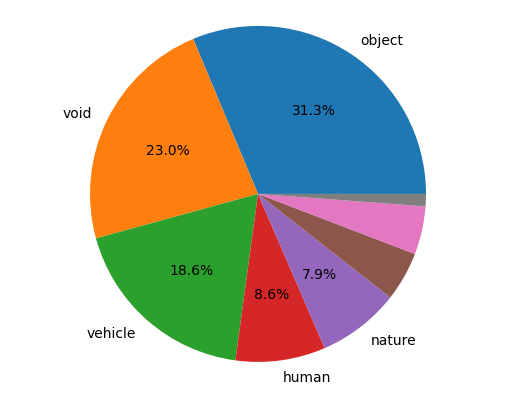

,%,%_cumul
label,,
pole,18.35,18.35
static,16.43,34.78
car,11.07,45.85
traffic sign,8.69,54.54
person,7.45,61.99
vegetation,6.17,68.16
traffic light,4.14,72.30
sidewalk,2.90,75.20
building,2.89,78.09


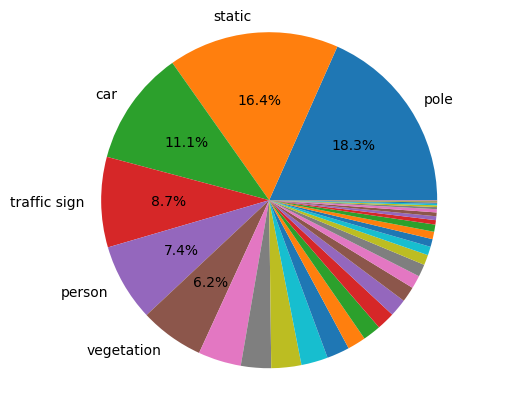

,%,%_cumul
label,,
strasbourg,9.91,9.91
hamburg,9.90,19.81
frankfurt,9.86,29.67
bremen,8.20,37.87
hanover,6.74,44.61
dusseldorf,6.24,50.85
munster,5.65,56.50
aachen,4.81,61.31
stuttgart,4.78,66.09


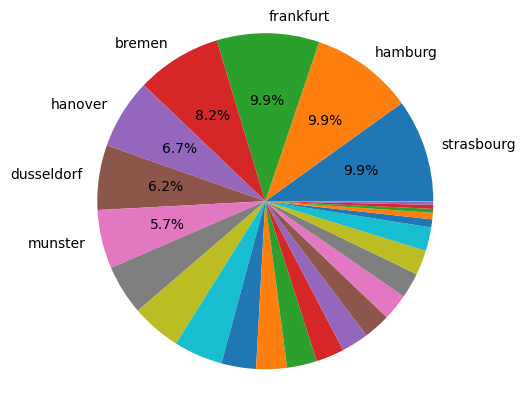

In [16]:
limit_perc = 5
for col in ['target', 'label', 'city']:
    show_unique_values(raw_data, col, cumul_threshold=101)

Quelles sont les villes les plus intéressantes ?

In [17]:
aggregations = {
    'target': ['size', lambda x: x.nunique()]
}

In [18]:
cities_agg = raw_data.groupby('city').agg(aggregations)
cities_agg.columns = pd.Index(['city_' + e[0] + "_" + e[1].upper() for e in cities_agg.columns.tolist()])
cities_agg.rename(columns={"city_target_SIZE": "nb_pics"}, inplace=True)
cities_agg.rename(columns={"city_target_<LAMBDA_0>": "nb_targets"}, inplace=True)

In [19]:
cities_agg.sort_values(by=['nb_targets', 'nb_pics'], ascending=False, inplace=True)

In [20]:
cities_agg

,nb_pics,nb_targets
city,,
strasbourg,28497,8
hamburg,28446,8
frankfurt,28339,8
bremen,23561,8
hanover,19381,8
dusseldorf,17924,8
munster,16250,8
aachen,13820,8
stuttgart,13736,8


Les villes avec uniquement 2 targets sont en réalité les data de test.

Pour le type de données train on a les villes suivantes :
['bremen' 'aachen' 'stuttgart' 'dusseldorf' 'hanover' 'cologne' 'erfurt'
 'jena' 'darmstadt' 'strasbourg' 'zurich' 'bochum' 'ulm' 'krefeld'
 'monchengladbach' 'hamburg' 'tubingen' 'weimar']


,%,%_cumul
label,,
object,31.53,31.53
void,21.69,53.22
vehicle,18.64,71.86
human,8.80,80.66
nature,8.26,88.92
construction,4.98,93.90
flat,4.85,98.75
sky,1.25,100.00


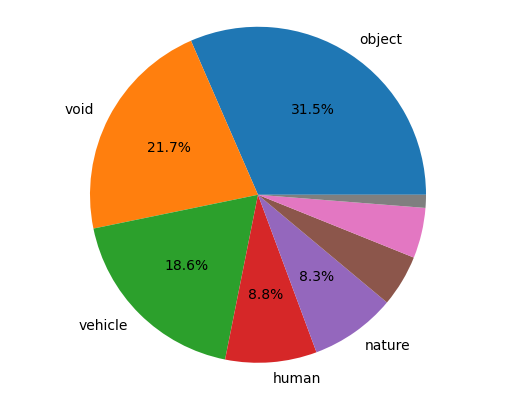

Pour le type de données val on a les villes suivantes :
['lindau' 'munster' 'frankfurt']


,%,%_cumul
label,,
object,33.47,33.47
void,24.42,57.89
vehicle,17.06,74.95
human,8.80,83.75
nature,7.13,90.88
construction,4.08,94.96
flat,4.03,98.99
sky,1.02,100.01


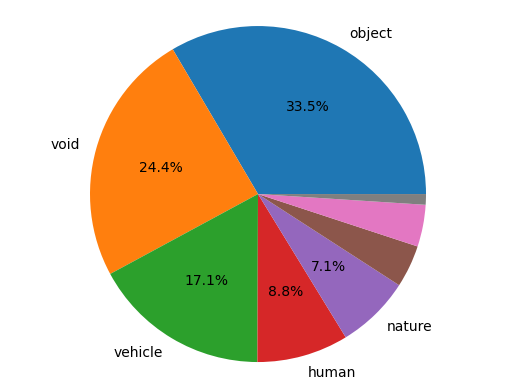

Pour le type de données test on a les villes suivantes :
['munich' 'mainz' 'berlin' 'leverkusen' 'bielefeld' 'bonn']


,%,%_cumul
label,,
void,69.29,69.29
vehicle,30.71,100.00


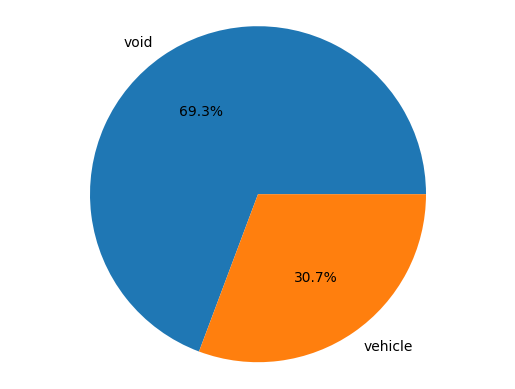

In [21]:
for set_type in ["train", "val", "test"]:
    temp_type_data = raw_data.loc[raw_data["set_type"] == set_type, :]
    print("Pour le type de données", set_type, "on a les villes suivantes :")
    print(temp_type_data["city"].unique())
    show_unique_values(temp_type_data, "target", cumul_threshold=105)

,%,%_cumul
label,,
object,31.85,31.85
void,22.14,53.99
vehicle,18.37,72.36
human,8.80,81.16
nature,8.08,89.24
construction,4.83,94.07
flat,4.71,98.78
sky,1.21,99.99


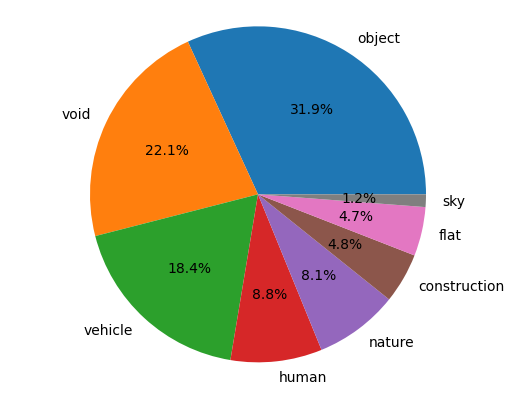

,%,%_cumul
label,,
object,31.85,31.85
void,22.14,53.99
vehicle,18.37,72.36
human,8.80,81.16
nature,8.08,89.24
construction,4.83,94.07
flat,4.71,98.78
sky,1.21,99.99


In [22]:
data_train_val = raw_data.loc[raw_data["set_type"].isin(["train", "val"]), :]
limit_perc = 1
show_unique_values(data_train_val, "target", cumul_threshold=105)

,%,%_cumul
label,,
void,22.75,22.75
object,22.25,45.00
vehicle,19.23,64.23
nature,16.49,80.72
construction,8.87,89.59
flat,5.45,95.04
human,2.84,97.88
sky,2.12,100.00


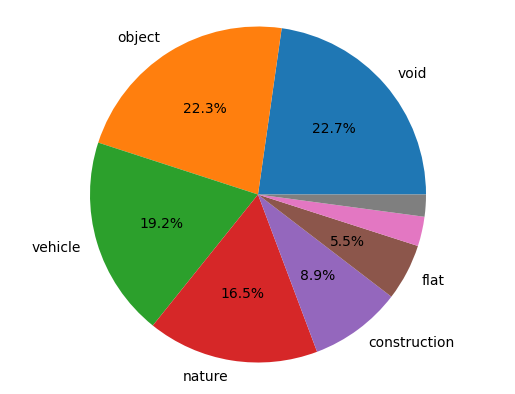

----------------------------------------------------------------------


,%,%_cumul
label,,
object,28.12,28.12
void,25.18,53.30
vehicle,19.73,73.03
nature,9.06,82.09
human,8.31,90.40
construction,4.27,94.67
flat,4.23,98.90
sky,1.09,99.99


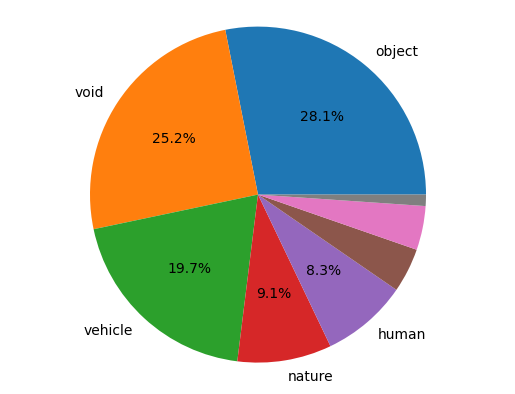

----------------------------------------------------------------------


,%,%_cumul
label,,
object,37.42,37.42
void,24.11,61.53
vehicle,15.35,76.88
human,9.55,86.43
nature,5.28,91.71
flat,3.80,95.51
construction,3.59,99.10
sky,0.90,100.00


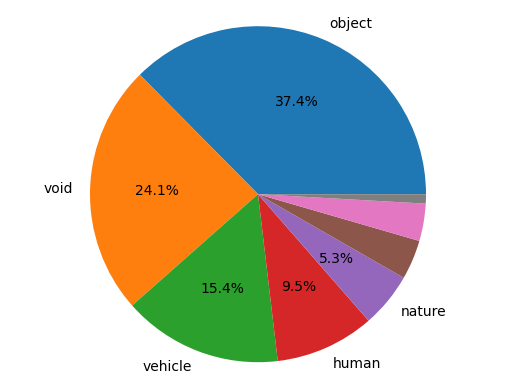

----------------------------------------------------------------------


,%,%_cumul
label,,
object,32.94,32.94
vehicle,19.63,52.57
void,18.98,71.55
nature,9.90,81.45
human,6.04,87.49
construction,5.85,93.34
flat,5.42,98.76
sky,1.25,100.01


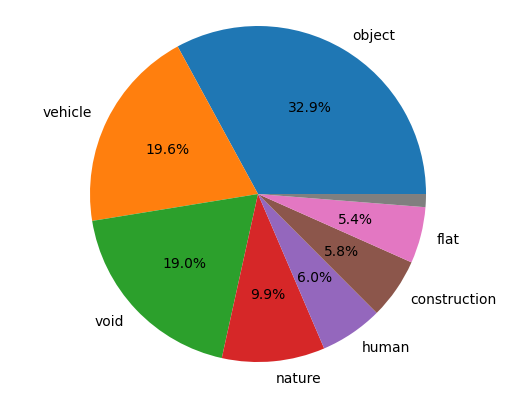

----------------------------------------------------------------------


,%,%_cumul
label,,
object,32.60,32.60
vehicle,23.37,55.97
void,16.34,72.31
human,9.31,81.62
nature,7.92,89.54
flat,5.35,94.89
construction,3.87,98.76
sky,1.23,99.99


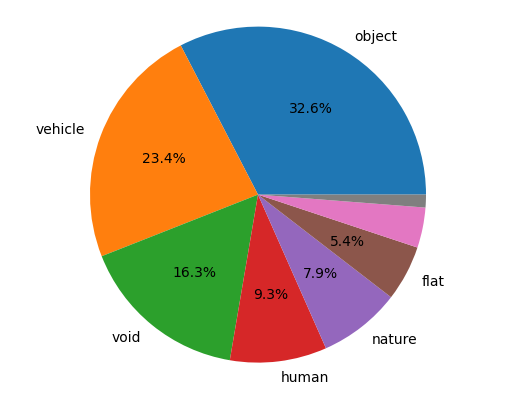

----------------------------------------------------------------------


,%,%_cumul
label,,
object,30.02,30.02
vehicle,22.30,52.32
void,21.05,73.37
nature,8.44,81.81
human,6.92,88.73
construction,5.53,94.26
flat,4.44,98.70
sky,1.30,100.00


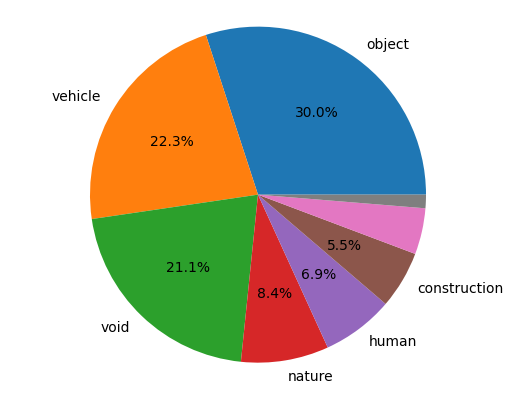

----------------------------------------------------------------------


,%,%_cumul
label,,
object,39.48,39.48
void,19.39,58.87
vehicle,18.76,77.63
nature,9.13,86.76
flat,5.17,91.93
construction,3.59,95.52
human,3.27,98.79
sky,1.21,100.00


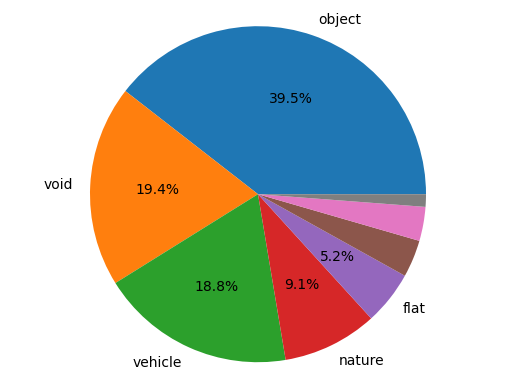

----------------------------------------------------------------------


,%,%_cumul
label,,
object,32.42,32.42
void,23.77,56.19
vehicle,19.36,75.55
human,10.04,85.59
nature,6.19,91.78
flat,3.86,95.64
construction,3.27,98.91
sky,1.08,99.99


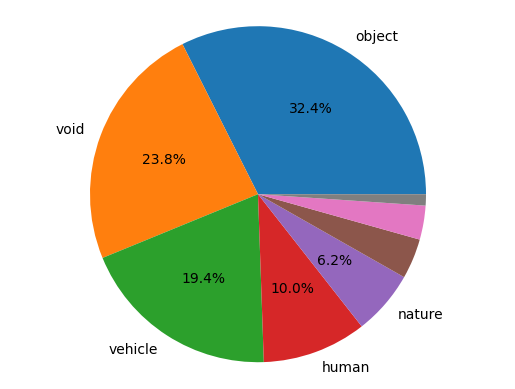

----------------------------------------------------------------------


,%,%_cumul
label,,
object,31.92,31.92
void,23.13,55.05
vehicle,20.76,75.81
human,8.71,84.52
nature,6.62,91.14
construction,3.85,94.99
flat,3.80,98.79
sky,1.21,100.00


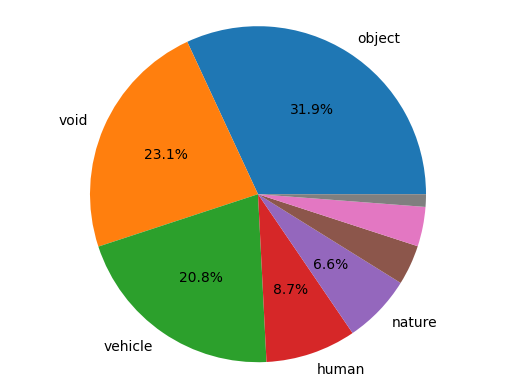

----------------------------------------------------------------------


,%,%_cumul
label,,
object,29.44,29.44
void,20.75,50.19
vehicle,18.06,68.25
nature,10.55,78.80
human,7.04,85.84
construction,6.87,92.71
flat,5.81,98.52
sky,1.49,100.01


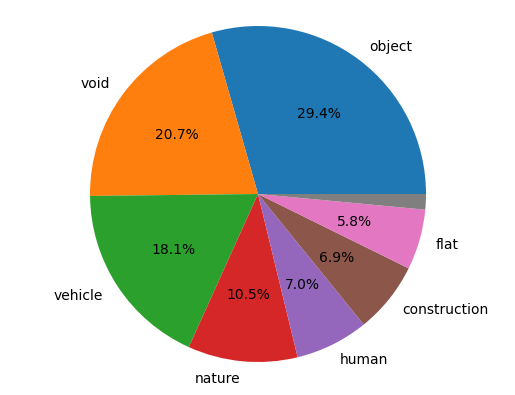

----------------------------------------------------------------------


,%,%_cumul
label,,
object,25.99,25.99
void,20.69,46.68
vehicle,16.97,63.65
nature,10.86,74.51
human,9.92,84.43
construction,8.39,92.82
flat,5.69,98.51
sky,1.48,99.99


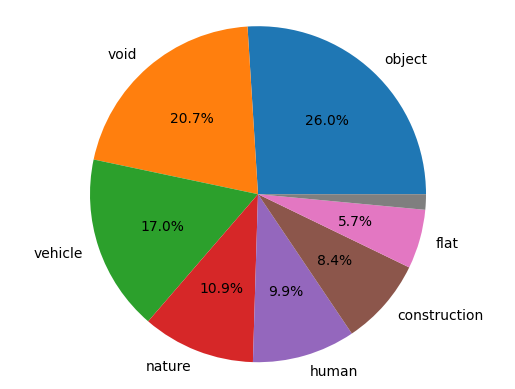

----------------------------------------------------------------------


,%,%_cumul
label,,
object,36.26,36.26
vehicle,21.25,57.51
void,19.83,77.34
human,6.33,83.67
nature,6.08,89.75
construction,4.80,94.55
flat,4.11,98.66
sky,1.35,100.01


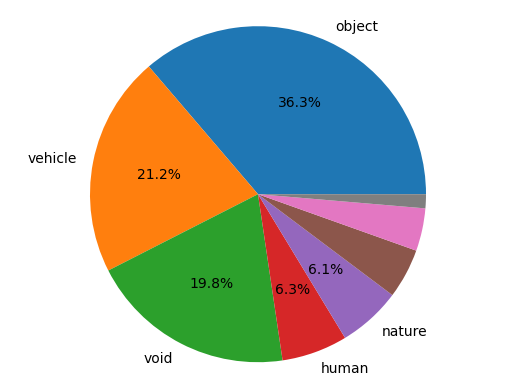

----------------------------------------------------------------------


,%,%_cumul
label,,
object,28.53,28.53
void,26.09,54.62
vehicle,16.48,71.10
human,11.79,82.89
nature,5.68,88.57
flat,5.45,94.02
construction,4.77,98.79
sky,1.22,100.01


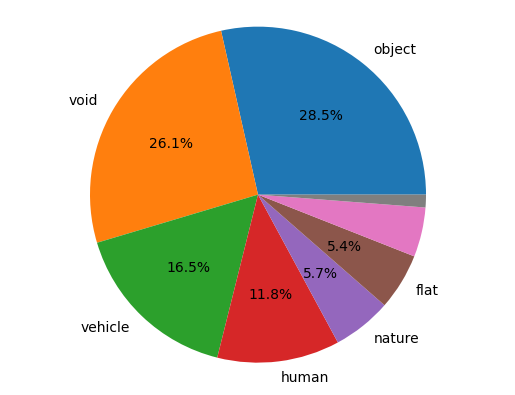

----------------------------------------------------------------------


,%,%_cumul
label,,
object,29.55,29.55
void,22.39,51.94
vehicle,16.14,68.08
human,10.77,78.85
nature,8.95,87.80
construction,6.24,94.04
flat,4.67,98.71
sky,1.28,99.99


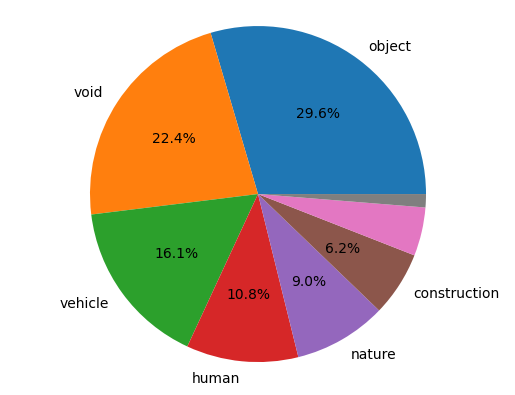

----------------------------------------------------------------------


,%,%_cumul
label,,
object,34.32,34.32
void,23.88,58.20
vehicle,18.36,76.56
nature,9.83,86.39
flat,5.24,91.63
construction,4.62,96.25
human,2.33,98.58
sky,1.41,99.99


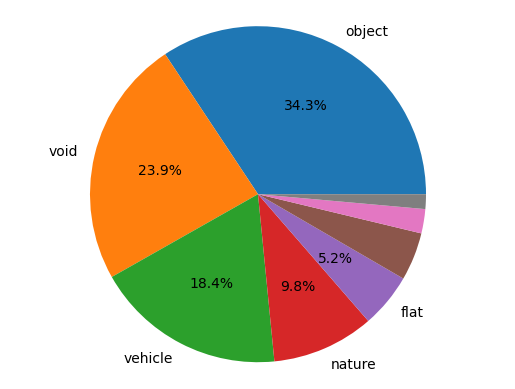

----------------------------------------------------------------------


,%,%_cumul
label,,
object,32.86,32.86
void,22.25,55.11
vehicle,17.64,72.75
nature,10.31,83.06
construction,6.17,89.23
flat,4.93,94.16
human,4.51,98.67
sky,1.33,100.00


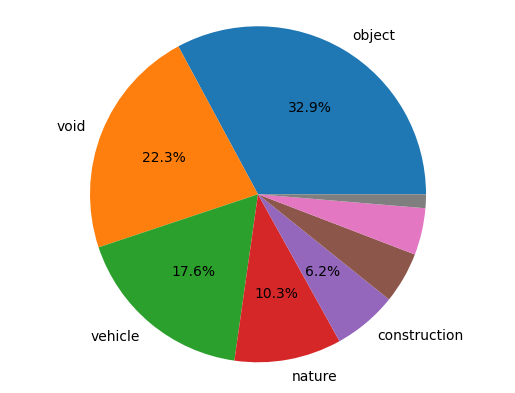

----------------------------------------------------------------------


,%,%_cumul
label,,
object,32.25,32.25
void,26.36,58.61
vehicle,15.76,74.37
nature,10.15,84.52
flat,5.04,89.56
construction,4.70,94.26
human,4.42,98.68
sky,1.32,100.00


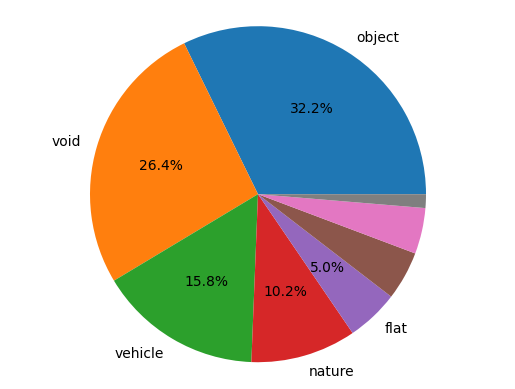

----------------------------------------------------------------------


,%,%_cumul
label,,
object,35.53,35.53
void,23.57,59.10
vehicle,14.87,73.97
nature,9.12,83.09
flat,5.84,88.93
construction,5.48,94.41
human,4.22,98.63
sky,1.38,100.01


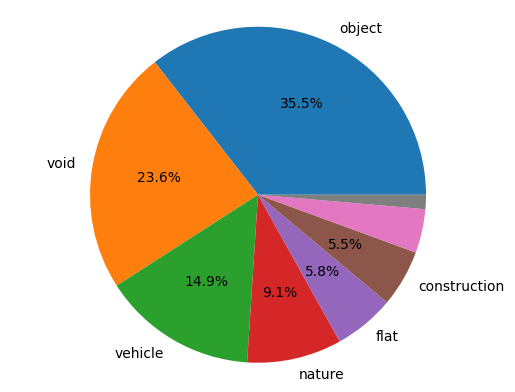

----------------------------------------------------------------------


,%,%_cumul
label,,
object,29.21,29.21
void,20.78,49.99
vehicle,17.65,67.64
human,17.27,84.91
nature,7.12,92.03
construction,3.68,95.71
flat,3.41,99.12
sky,0.90,100.02


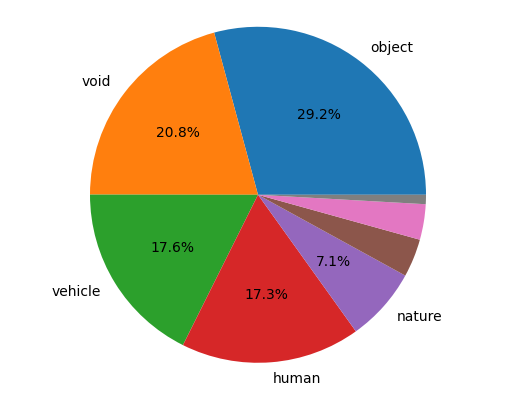

----------------------------------------------------------------------


,%,%_cumul
label,,
object,25.60,25.60
void,21.68,47.28
vehicle,16.64,63.92
nature,13.05,76.97
construction,8.62,85.59
human,6.95,92.54
flat,5.87,98.41
sky,1.58,99.99


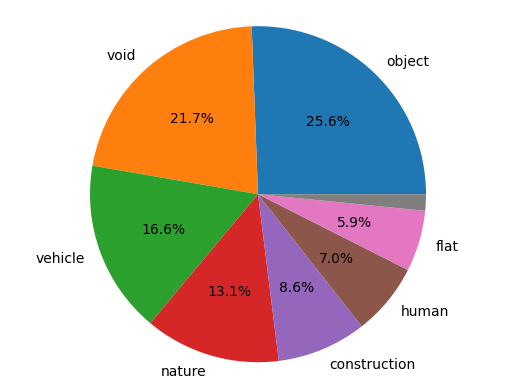

----------------------------------------------------------------------


,%,%_cumul
label,,
object,29.36,29.36
void,19.21,48.57
vehicle,18.45,67.02
nature,8.99,76.01
human,8.74,84.75
construction,7.30,92.05
flat,6.15,98.20
sky,1.81,100.01


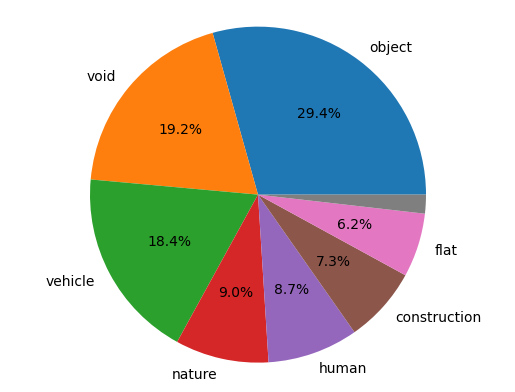

----------------------------------------------------------------------


In [23]:
limit_perc = 5
for city in raw_data["city"].unique():
    temp_data = raw_data.loc[raw_data["city"] == city, :]
    nb_unique_target = len(temp_data["target"].unique())
    if nb_unique_target == 2:
        continue
    # print("Pour la ville de", city, "nous avons", nb_unique_target, "targets différentes.")
    show_unique_values(temp_data, "target", cumul_threshold=101)
    print("-"*70)

<Axes: xlabel='city'>

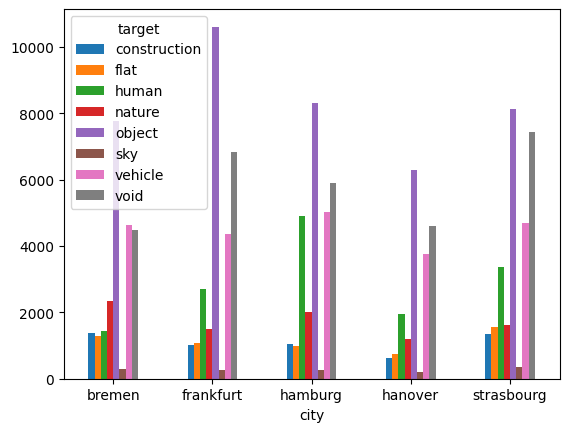

In [24]:
sample_data = raw_data.loc[raw_data["city"].isin(cities_agg.index[:5]), :]
sample_data.groupby("target")["city"].value_counts().unstack(0).plot.bar(rot=0)

### Explore the labelIds files

# Explore the raw pictures

In [25]:
dict_cities_annot, count_files_by_cities_annot = explore_data_folders("P8_Cityscapes_leftImg8bit_trainvaltest/")

Il y a 27 villes au total et 27 villes uniques.
Il y a 5000 fichiers dans nos données.


Les données consistent en 5 000 fichiers images brutes.

Le format des fichiers est le suivant : "nom ville" _ "code image sur 12 chiffres par groupe de 6" _ "nom dossier 'leftImg8bit'".png